In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import streamlit as st
import unicodedata
import optuna
from nba_api.stats.static import players
from nba_api.stats.endpoints import playercareerstats
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score 
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
import shap
from IPython.display import Markdown, display

In [ ]:
alllineup_stats = pd.read_csv("alllineup_stats.csv")
player_names = pd.read_csv("player_names.csv")
player_names = player_names["Unnamed: 3"]
all_players = players.get_players()
players_dict = {player['full_name']: player['id'] for player in all_players}

players_dict['Bogdan Bogdanovic'] = 203992
players_dict['Kristaps Porzingis'] = 204001
players_dict['Nikola Vucevic'] = 202696
players_dict['Vasilije Micic'] = 203995
players_dict['Luka Doncic'] = 1629029
players_dict['Dante Exum'] = 203957
players_dict['Nikola Jokic'] = 203999
players_dict['Bojan Bogdanovic'] = 202711
players_dict['Jonas Valanciunas'] = 202685
players_dict['Dennis Schroder'] = 203471
players_dict['Jusuf Nurkic'] = 203994
players_dict['Nikola Jovic'] = 1631107

def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return u"".join([c for c in nfkd_form if not unicodedata.combining(c)])
player_ids = {name: players_dict.get(remove_accents(name)) for name in player_names}

season_stats = pd.DataFrame()
player_ids_list = list(player_ids.items())
for player_name, player_id in player_ids_list:
    try:
        career = playercareerstats.PlayerCareerStats(player_id=player_id)
        career_df = career.get_data_frames()[0]
        season_2023_24 = career_df[career_df["SEASON_ID"] == "2023-24"].copy()
        if not season_2023_24.empty:
            season_2023_24['Player_Name'] = player_name 
            season_stats = pd.concat([season_stats, season_2023_24], ignore_index=True)
    except Exception as e:
        print(f"Error fetching stats for {player_name} (ID: {player_id}): {e}")

In [5]:
extra_stats = pd.merge(extra_stats, team_misc_stats[['Team', 'Pace']], on="Team", how="inner")
extra_stats["Player Name"] = extra_stats["Player"].apply(lambda player: f"{player.split()[0][0]}. {player.split()[-1]}")
columns = ['FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 
           'OREB', 'DREB','REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']
for column in columns:
    extra_stats[column] = (extra_stats[column]*(48/extra_stats["MIN"]))*(100/extra_stats["Pace"])
    
stats_2324 = pd.concat([season_stats, extra_stats])

df_merged = pd.merge(stats_2324, team_stats[["Team", "MP_team", "FG_team" ,"FGA_against", "3PA_against", 
                                             "ORB_for", "DRB_for", "ORB_against", "DRB_against"]], 
                     on="Team", how="inner")
df_merged["ORB_PCT"] = df_merged["OREB"] / (df_merged["ORB_for"] + df_merged["DRB_against"])
df_merged["DRB_PCT"] = df_merged["DREB"] / (df_merged["ORB_against"] + df_merged["DRB_for"])
df_merged["AST_PCT"] = df_merged["AST"] / (df_merged["FGA"] - df_merged["OREB"] + df_merged["TOV"] + 0.44 * df_merged["FTA"])
# df_merged["AST_PCT"] = df_merged["AST"] / (((df_merged["MIN"] / df_merged["MP_team"]) * df_merged["FG_team"]) - df_merged["FGM"])
df_merged["STL_PCT"] = (df_merged["STL"] * df_merged["MP_team"]) / (df_merged["MIN"] * df_merged["Pace"])
df_merged["BLK_PCT"] = (df_merged["BLK"] * df_merged["MP_team"]) / (df_merged["MIN"] * (df_merged["FGA_against"] - df_merged["3PA_against"]))
df_merged["TOV_PCT"] = df_merged["TOV"] / (df_merged["FGA"] + 0.44 * df_merged["FTA"] + df_merged["TOV"])
df_merged.drop(['ORB_for', 'DRB_for', 'ORB_against', 'DRB_against', "MP_team", "FG_team" ,"FGA_against", "3PA_against"], axis=1, inplace=True)

stats_2324[['ORB_PCT', 'DRB_PCT', 'AST_PCT', 'STL_PCT', 'BLK_PCT', 'TOV_PCT']] = df_merged[['ORB_PCT', 'DRB_PCT', 'AST_PCT', 'STL_PCT', 'BLK_PCT', 'TOV_PCT']]
stats_2324 = stats_2324.drop("REB", axis=1)
stats_2324["FG_PCT"] = stats_2324["FGM"] / stats_2324["FGA"]
stats_2324["FG3_PCT"] = stats_2324["FG3M"] / stats_2324["FG3A"]
stats_2324["FT_PCT"] = stats_2324["FTM"] / stats_2324["FTA"]
stats_2324.fillna(0, inplace=True)
stats_2324 = stats_2324[["Player", "Player Name", "Team", "Age", "GP", "GS", "MIN", "FGM", "FGA",
                         "FG_PCT", "FG3M", "FG3A", "FG3_PCT", "FTM", "FTA", "FT_PCT", "OREB", "ORB_PCT",
                         "DREB", "DRB_PCT", "AST", "AST_PCT", "STL", "STL_PCT", "BLK", "BLK_PCT", 
                         "TOV", "TOV_PCT", "PF", "PTS"]]

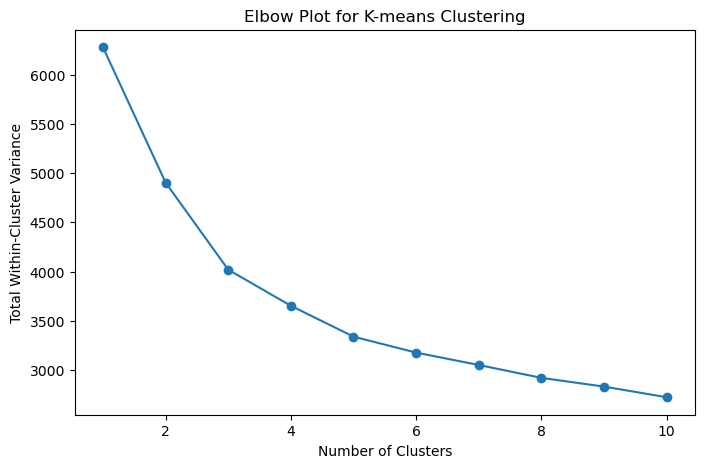

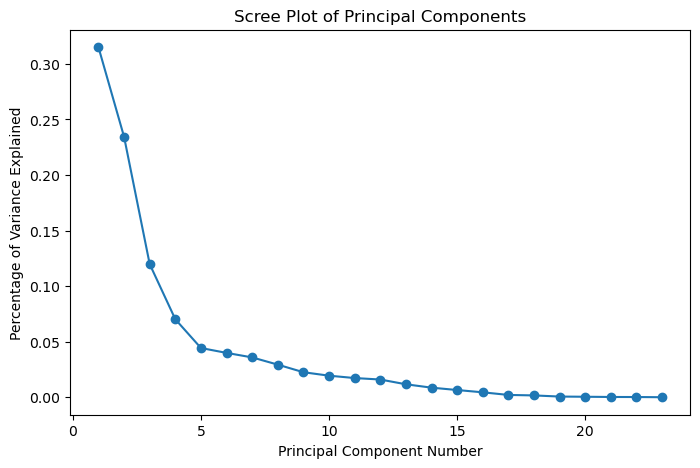

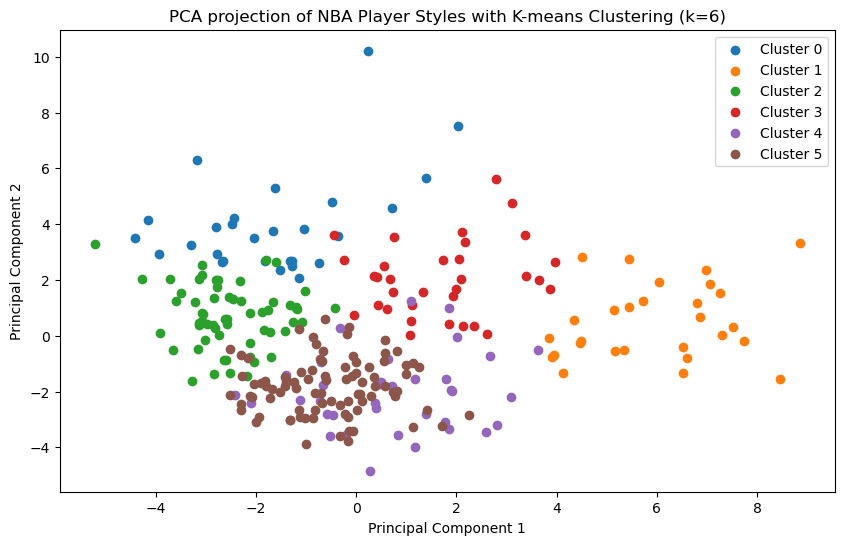

In [284]:
columns = ['FGM', 'FGA','FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 
           'OREB','ORB_PCT', 'DREB', 'DRB_PCT', 'AST', 'AST_PCT', 'STL', 'STL_PCT', 
           'BLK','BLK_PCT', 'TOV', 'TOV_PCT', 'PF', 'PTS']
# columns = ['FG_PCT', 'FG3_PCT', 'FT_PCT', 'ORB_PCT', 'DRB_PCT', 'AST_PCT', 'STL_PCT', 'BLK_PCT', 'TOV_PCT']
stats_2324_mean = stats_2324[columns].mean()
stats_2324_std = stats_2324[columns].std()
standardized = (stats_2324[columns] - stats_2324_mean) / stats_2324_std
stats_2324_norm = stats_2324.copy()
stats_2324_norm[columns] = standardized

inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(standardized)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Total Within-Cluster Variance")
plt.title("Elbow Plot for K-means Clustering")
plt.savefig("elbow", dpi=300)
plt.show()

best_k = 6
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
stats_2324_norm['Cluster'] = kmeans.fit_predict(standardized)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(standardized)

pca_full = PCA()
pca_full.fit(standardized)

explained_variance_ratio = pca_full.explained_variance_ratio_

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.xlabel("Principal Component Number")
plt.ylabel("Percentage of Variance Explained")
plt.title("Scree Plot of Principal Components")
plt.savefig("scree_plot.png", dpi=300)
plt.show()

stats_2324_norm['PC1'], stats_2324_norm['PC2'] = X_pca[:, 0], X_pca[:, 1]

plt.figure(figsize=(10, 6))
for cluster in range(best_k):
    subset = stats_2324_norm[stats_2324_norm['Cluster'] == cluster]
    plt.scatter(subset['PC1'], subset['PC2'], label=f"Cluster {cluster}")

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA projection of NBA Player Styles with K-means Clustering (k=6)")
plt.legend()
plt.savefig('Cluster.png', dpi=300)
plt.show()

In [240]:
stats_2324_norm

,Unnamed: 0,Player,Player Name,Team,Age,GP,GS,MIN,FGM,FGA,...,STL_PCT,BLK,BLK_PCT,TOV,TOV_PCT,PF,PTS,Cluster,PC1,PC2
0,0,Bogdan Bogdanovic,Bogdan Bogdanovic,ATL,31,79,33,30.392405,0.339904,0.799426,...,0.137883,-0.610767,-0.619783,-0.389772,-0.934565,-0.146666,0.492721,3,-3.147671,-0.492883
1,1,Dejounte Murray,D. Murray,ATL,27,78,78,35.679487,1.185246,1.425902,...,-0.204164,-0.732460,-0.757686,0.855843,-0.123190,-1.262189,0.990347,2,-2.531199,1.405861
2,2,Saddiq Bey,S. Bey,ATL,25,63,51,32.730159,-0.696356,-0.314619,...,-0.830813,-0.913984,-0.852407,-1.386141,-1.657865,-1.570936,-0.417532,3,-0.725875,-0.833307
3,3,Jalen Johnson,J. Johnson,ATL,22,56,52,33.732143,0.225681,-0.002965,...,-0.319036,0.164746,-0.160940,-0.057623,-0.014946,-0.331860,-0.045868,6,1.100675,0.534808
4,4,Clint Capela,C. Capela,ATL,30,73,73,25.794521,0.177518,-0.405709,...,-0.606539,1.898342,1.577635,-0.747635,-0.703438,0.413779,-0.248038,5,7.061441,1.857258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,269,Dennis Smith,D. Smith,BRK,26,56,2,18.900000,-0.668943,-0.408080,...,3.805505,-0.605102,1.913393,0.532695,0.202477,1.895056,-0.802437,6,3.631202,-0.519116
270,270,Ish Smith,I. Smith,CHO,35,43,5,17.200000,-1.646643,-1.397072,...,1.713002,-0.878297,0.654064,0.542681,1.007542,-0.538014,-1.930352,1,-0.206690,-3.559673
271,271,Nick Richards,N. Richards,CHO,26,67,51,26.300000,-0.473979,-1.417954,...,-1.088869,1.166296,-0.094204,-0.565997,-0.958079,1.066553,-0.677905,5,5.443056,1.017472
272,272,Peyton Watson,P. Watson,DEN,21,80,4,18.600000,-0.623385,-0.562079,...,-0.839412,2.166711,-0.673554,-0.766219,-0.221019,0.993681,-0.724129,4,1.245612,-1.136809


In [390]:
c0 = stats_2324_norm[stats_2324_norm["Cluster"] == 5][['FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 
                                                       'OREB', 'ORB_PCT', 'DREB', 'DRB_PCT', 'AST', 'AST_PCT', 'STL', 'STL_PCT', 
                                                       'BLK', 'BLK_PCT', 'TOV', 'TOV_PCT', 'PF', 'PTS']]
c0_mean = c0.mean()

distances = cdist(c0[c0_mean.index], [c0_mean], metric='euclidean').flatten()
c0_with_dist = c0.copy()
c0_with_dist["DistanceToMean"] = distances
c0_with_dist = c0_with_dist.merge(stats_2324_norm[["Player Name"]], left_index=True, right_index=True)
closest_player = c0_with_dist.sort_values(by="DistanceToMean").iloc[0]
print("Most representative player of Cluster 0:")
print(closest_player["Player Name"])

Most representative player of Cluster 0:
Caleb Martin


In [9]:
subset1 = stats_2324_norm[stats_2324_norm['Cluster'] == 1]
subset2 = stats_2324_norm[stats_2324_norm['Cluster'] == 2]
chosen_player = subset1[subset1['Player'] == "Nick Richards"]
chosen_player_vector = chosen_player.drop(columns=['Player Name', 'Team', 'Age', 'GP', 'GS', 'MIN', 'Player', 'Cluster']).values
subset2_features = subset2.drop(columns=['Player Name', 'Team', 'Age', 'GP', 'GS', 'MIN', 'Player', 'Cluster'])
distances = cdist(chosen_player_vector, subset2_features.values, metric='euclidean')[0]
farthest_indices = np.argsort(distances)[-5:][::-1]
farthest_players = subset2.iloc[farthest_indices][['Player']]
farthest_distances = distances[farthest_indices]
farthest_players['Distance'] = farthest_distances
print(farthest_players)

                Player   Distance
54       Stephen Curry  16.312429
155    Anfernee Simons  14.462501
71   Tyrese Haliburton  14.122249
55       Klay Thompson  14.029644
92        Luke Kennard  13.696957


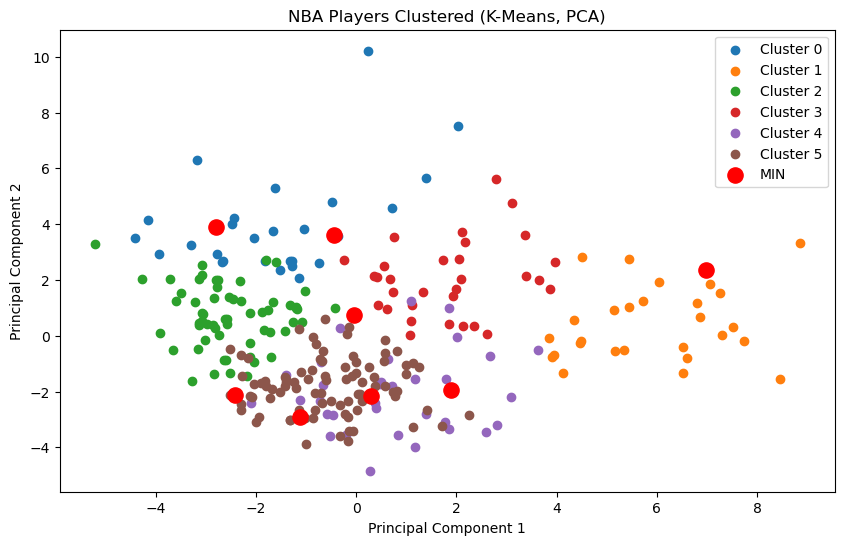

,Player,PC1,PC2,Cluster
110,Jaden McDaniels,0.302355,-2.171883,5
111,Rudy Gobert,6.983989,2.371216,1
112,Mike Conley,-2.421529,-2.131620,4
113,Nickeil Alexander-Walker,-1.116867,-2.902491,5
114,Kyle Anderson,1.897422,-1.957918,4
115,Anthony Edwards,-2.791546,3.905666,0
226,Karl-Anthony Towns,-0.443009,3.617926,3
227,Naz Reid,-0.034946,0.744527,3


In [6]:
def plot_cluster(team_name):
    team = stats_2324_norm[stats_2324_norm["Team"] == team_name]
    # team2 = stats_2324_norm[stats_2324_norm["Player"] == "Paul George"]
    plt.figure(figsize=(10, 6))
    for cluster in range(best_k):
        subset = stats_2324_norm[stats_2324_norm['Cluster'] == cluster]
        plt.scatter(subset['PC1'], subset['PC2'], label=f"Cluster {cluster}")
    plt.scatter(team["PC1"], team["PC2"], label=team_name, color="r", s=120)
    # plt.scatter(team2["PC1"], team2["PC2"], label="George", color="yellow", s=120)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title("NBA Players Clustered (K-Means, PCA)")
    plt.legend()
    plt.show()
    return team
team = plot_cluster("MIN")
team[["Player", "PC1", "PC2", "Cluster"]]

In [301]:
stats_2324_norm[stats_2324_norm["Player"] == "Julian Champagnie"]["Cluster"]

170    5
Name: Cluster, dtype: int32

In [5]:
def euclidean(player1, player2):
    player1_pc = stats_2324_norm[stats_2324_norm["Player"] == player1][["PC1", "PC2"]]
    player2_pc = stats_2324_norm[stats_2324_norm["Player"] == player2][["PC1", "PC2"]]
    distance = np.sqrt((np.array(player1_pc)[0][0] - np.array(player2_pc)[0][0])**2 + 
                       (np.array(player1_pc)[0][1] - np.array(player2_pc)[0][1])**2)
    return distance
distance = euclidean("Stephen Curry", "Rudy Gobert")
print(distance)

12.232128668443123


We are just going to divide all the lineup minute data by the lower of the games played by the two players to get an estimate to minutes per game.

Cluster 0: scorers <br>
Cluster 1: big men <br>
Cluster 2: shooters <br>
Cluster 3: unicorns <br>
Cluster 4: 3&d guards <br>
Cluster 5: 3&d forwards <br>

Choose Team - Show Composition by Cluster <br>
Choose Team - Show Clustering on Plot

Ideas: 
Jaylen Brown 02- edge scorer: compatible with players between [2.09, 3.28] (tatum, white)
Anthony Davis 03- unicorn: 0s and 2s
Jokic 03 - unicorn: within [5, 9]
Giannis 03 - within 8?
Jalen Brunson 0 - box around jhart 7

In [107]:
def data_merged(data):
    data["FGM"] = data["FGM_1"] + data["FGM_2"]
    data["FGA"] = data["FGA_1"] + data["FGA_2"]
    data["FG_PCT"] = (data["FG_PCT_1"] + data["FG_PCT_2"]) / 2
    data["eFG_PCT"] = (data["eFG%_1"] + data["eFG%_2"]) / 2
    data["FG3M"] = data["FG3M_1"] + data["FG3M_2"]
    data["FG3A"] = data["FG3A_1"] + data["FG3A_2"]
    data["FG3_PCT"] = (data["FG3_PCT_1"] + data["FG3_PCT_2"]) / 2
    data["FTM"] = data["FTM_1"] + data["FTM_2"]
    data["FTA"] = data["FTA_1"] + data["FTA_2"]
    data["FT_PCT"] = (data["FT_PCT_1"] + data["FT_PCT_2"]) / 2
    data["AST"] = data["AST_1"] + data["AST_2"]
    data["AST_PCT"] = (data["AST_PCT_1"] + data["AST_PCT_2"]) / 2
    data["AST_DIFF"] = abs(data["AST_1"] - data["AST_2"])
    data["OREB"] = data["OREB_1"] + data["OREB_2"]
    data["OREB_PCT"] = (data["ORB_PCT_1"] + data["ORB_PCT_2"]) / 2
    data["OREB_DIFF"] = abs(data["OREB_1"] - data["OREB_2"])
    data["DREB"] = data["DREB_1"] + data["DREB_2"]
    data["DREB_PCT"] = (data["DRB_PCT_1"] + data["DRB_PCT_2"]) / 2
    data["DREB_DIFF"] = abs(data["DREB_1"] - data["DREB_2"])
    data["STL"] = data["STL_1"] + data["STL_2"]
    data["STL_PCT"] = (data["STL_PCT_1"] + data["STL_PCT_2"]) / 2
    data["STL_DIFF"] = abs(data["STL_1"] - data["STL_2"])
    data["BLK"] = data["BLK_1"] + data["BLK_2"]
    data["BLK_PCT"] = (data["BLK_PCT_1"] + data["BLK_PCT_2"]) / 2
    data["BLK_DIFF"] = abs(data["BLK_1"] - data["BLK_2"])
    data["TOV"] = data["TOV_1"] + data["TOV_2"]
    data["TOV_PCT"] = (data["TOV_PCT_1"] + data["TOV_PCT_2"]) / 2
    data["TOV_DIFF"] = abs(data["TOV_1"] - data["TOV_2"])
    data["PF"] = data["PF_1"] + data["PF_2"]
    data["PF_DIFF"] = abs(data["PF_1"] - data["PF_2"])
    data["PTS"] = data["PTS_1"] + data["PTS_2"]
    data["PTS_DIFF"] = abs(data["PTS_1"] - data["PTS_2"])
    data["DIST"] = data.apply(lambda row: euclidean(row["Player_1"], row["Player_2"]), axis=1)
    data = data.drop(columns=['FGM_1', 'FGA_1', 'FG_PCT_1', 'FG3M_1', 'FG3A_1', 'FG3_PCT_1', 'FTM_1', 
                              'FTA_1','FT_PCT_1', 'OREB_1', 'ORB_PCT_1', 'DREB_1', 'DRB_PCT_1', 
                              'AST_1', 'AST_PCT_1', 'STL_1', 'STL_PCT_1', 'BLK_1', 'BLK_PCT_1', 
                              'TOV_1', 'TOV_PCT_1', 'PF_1', 'PTS_1', 'FGM_2', 'FGA_2', 'FG_PCT_2', 
                              'FG3M_2','FG3A_2', 'FG3_PCT_2', 'FTM_2', 'FTA_2', 'FT_PCT_2', 'OREB_2',
                              'ORB_PCT_2', 'DREB_2', 'DRB_PCT_2', 'AST_2', 'AST_PCT_2', 'STL_2',
                              'STL_PCT_2', 'BLK_2', 'BLK_PCT_2', 'TOV_2', 'TOV_PCT_2', 'PF_2','PTS_2',
                              'eFG%_1', 'eFG%_2'])
    return data

In [7]:
minute_data = alllineup_stats[["Player 1", "Player 2", "Team", "MP"]].copy()
minute_data.loc[:, "MP_seconds"] = minute_data["MP"].apply(lambda x: sum(int(t) * 60**i for i, t in enumerate(reversed(x.split(":")))))
minute_data = minute_data.sort_values(by="MP_seconds", ascending=False).drop(columns=["MP_seconds"])

minute_data.loc[:, "MP_seconds"] = minute_data["MP"].apply(lambda x: sum(int(t) * 60**i for i, t in enumerate(reversed(x.split(":")))))

minute_data = minute_data.merge(
    stats_2324[["Player Name", "Team", "GP"]], 
    left_on=["Player 1", "Team"], 
    right_on=["Player Name", "Team"], 
    how="left"
).rename(columns={"GP": "GP_1"}).drop(columns=["Player Name"])

minute_data = minute_data.merge(
    stats_2324[["Player Name", "Team", "GP"]], 
    left_on=["Player 2", "Team"], 
    right_on=["Player Name", "Team"], 
    how="left"
).rename(columns={"GP": "GP_2"}).drop(columns=["Player Name"])

minute_data["Min_GP"] = minute_data[["GP_1", "GP_2"]].min(axis=1)
minute_data["MP_per_GP"] = minute_data["MP_seconds"] / minute_data["Min_GP"]
minute_data = minute_data.sort_values(by="MP_per_GP", ascending=False).drop(columns=["MP_seconds", "Min_GP", "MP", "GP_1", "GP_2"])
minute_data["MP_per_GP"] = minute_data["MP_per_GP"].apply(
    lambda x: f"{int(x // 3600)}:{int((x % 3600) // 60):02}:{int(x % 60):02}" if pd.notna(x) else "0:00:00"
)

# minute = []
# for data in minute_data["MP_per_GP"]:
#     minute.append(data.split(":")[0])
# plt.hist(minute, bins=len(set(minute)), edgecolor="black")
# plt.show()

minute_data = minute_data.merge(stats_2324, left_on=["Player 1", "Team"], right_on=["Player Name", "Team"],  how="left", suffixes=("", "_1")).drop(columns=["Player Name"])
minute_data = minute_data.merge(stats_2324, left_on=["Player 2", "Team"],  right_on=["Player Name", "Team"],  how="left",suffixes=("_1", "_2")).drop(columns=["Player Name"])  
# minute_data = minute_data.drop(columns=["Age_1", "GP_1", "GS_1", "MIN_1", "Age_2", "GP_2", "GS_2", "MIN_2"])
minute_data = minute_data.dropna()
stats_2324_merged = minute_data.copy()
stats_2324_merged = data_merged(stats_2324_merged)

In [100]:
minute_data["IT1"] = (minute_data["AST_1"] * minute_data["FG3_PCT_2"] + minute_data["AST_2"] * minute_data["FG3_PCT_1"]) / 2
minute_data["IT2"] = (minute_data["STL_1"] * minute_data["BLK_2"] + minute_data["STL_2"] * minute_data["BLK_1"]) / 2
minute_data["eFG%_2"] = (minute_data["FGA_2"] + 0.5 * minute_data["FG3M_2"]) / minute_data["FGM_2"]
minute_data["eFG%_1"] = (minute_data["FGA_1"] + 0.5 * minute_data["FG3M_1"]) / minute_data["FGM_1"]
minute_data["IT3"] = (minute_data["ORB_PCT_1"] * minute_data["eFG%_2"] + minute_data["ORB_PCT_2"] * minute_data["eFG%_1"]) / 2

In [96]:
hypothetical_df["IT1"] = (hypothetical_df["AST_1"] * hypothetical_df["FG3_PCT_2"] + hypothetical_df["AST_2"] * hypothetical_df["FG3_PCT_1"]) / 2
hypothetical_df["IT2"] = (hypothetical_df["STL_1"] * hypothetical_df["BLK_2"] + hypothetical_df["STL_2"] * hypothetical_df["BLK_1"]) / 2
hypothetical_df["eFG%_2"] = (hypothetical_df["FGA_2"] + 0.5 * hypothetical_df["FG3M_2"]) / hypothetical_df["FGM_2"]
hypothetical_df["eFG%_1"] = (hypothetical_df["FGA_1"] + 0.5 * hypothetical_df["FG3M_1"]) / hypothetical_df["FGM_1"]
hypothetical_df["IT3"] = (hypothetical_df["ORB_PCT_1"] * hypothetical_df["eFG%_2"] + hypothetical_df["ORB_PCT_2"] * hypothetical_df["eFG%_1"]) / 2

In [110]:
stats_2324_merged["SEC"] = stats_2324_merged["MP_per_GP"].apply(lambda x: sum(int(t) * f for t, f in zip(x.split(":"), [60, 1, 0.001])))
X = stats_2324_merged.drop(columns=["Age_1", "GP_1", "GS_1", "MIN_1", "Age_2", "GP_2", "GS_2", "MIN_2", "MP_per_GP", "Player 1", "Player 2", "Team", "SEC", "Player_1", "Player_2", "Unnamed: 0_1", "Unnamed: 0_2"])
y = stats_2324_merged["SEC"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [40]:
players = stats_2324[["Player Name", "Team"]]
team_combos = list(itertools.combinations(players["Team"].unique(), 2))
hypothetical_duos = []
for team1, team2 in team_combos:
    team1_players = players[players["Team"] == team1]["Player Name"].tolist()
    team2_players = players[players["Team"] == team2]["Player Name"].tolist()
    for p1, p2 in itertools.product(team1_players, team2_players):
        hypothetical_duos.append([p1, p2, team1, team2])
hypothetical_df = pd.DataFrame(hypothetical_duos, columns=["Player 1", "Player 2", "Team 1", "Team 2"])

player_1_stats = stats_2324.add_suffix("_1")
player_1_stats = player_1_stats.rename(columns={"Player Name_1": "Player Name", "Team_1": "Team"}) 

hypothetical_df = hypothetical_df.merge(
    player_1_stats, left_on=["Player 1", "Team 1"], right_on=["Player Name", "Team"], how="left"
).drop(columns=["Player Name", "Team", "Age_1", "GS_1", "GP_1", "MIN_1"])

player_2_stats = stats_2324.add_suffix("_2")
player_2_stats = player_2_stats.rename(columns={"Player Name_2": "Player Name", "Team_2": "Team"})

hypothetical_df = hypothetical_df.merge(
    player_2_stats, left_on=["Player 2", "Team 2"], right_on=["Player Name", "Team"], how="left"
).drop(columns=["Player Name", "Team", "Age_2", "GP_2", "GS_2", "MIN_2"])
hypothetical_sample = data_merged(hypothetical_df)# hypothetical_df.copy()
# hypothetical_sample = hypothetical_df.sample(n=58, random_state=42)

In [37]:
def minutes(seconds):
    minutes = int(seconds // 60)
    remaining_seconds = int(seconds % 60)
    milliseconds = int((seconds - int(seconds)) * 1000)
    return f"{minutes:02}:{remaining_seconds:02}:{milliseconds:03}"

In [151]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
print(f"Validation MAE: {mean_absolute_error(y_val, y_pred)} = {minutes(mean_absolute_error(y_val, y_pred))}")

Validation MAE: 134.0374386206896 = 02:14:037


In [61]:
# with bayesian optimized parameters
def kfold_xgboost(X, y):
    params = {
        "objective": "reg:squarederror", 
        "eval_metric": "mae",  
        "learning_rate": 0.0277346218779652, # 0.014815808564033127,
        "max_depth": 5, # 3,
        "subsample": 0.8147729473693605, # 0.7204240724500527,
        "colsample_bytree": 0.8709546325764835, # 0.8730074566604107, 
        "lambda": 0.3687671325331307, # 0.031618802012008694,
        "alpha": 0.1305709972052336, #1.9610506470727835,
        "min_child_weight": 4.671973265939742, # 5.714326480957027,
    }
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)

    kf = KFold(n_splits=5, shuffle=True)
    mae_scores = []
    best_iterations = []
    fold_models = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        dtrain_reg = xgb.DMatrix(X_train_fold, y_train_fold)
        dval_reg = xgb.DMatrix(X_val_fold, y_val_fold)

        model = xgb.train(params, dtrain_reg, num_boost_round=328, evals=[(dtrain_reg, "Train"), (dval_reg, "Validation")], 
                          verbose_eval=100, early_stopping_rounds=100)

        y_pred = model.predict(dval_reg)
        mae = mean_absolute_error(y_val_fold, y_pred)
        mae_scores.append(mae)
        best_iterations.append(model.best_iteration)
        fold_models.append(model)
        print(f"Fold MAE: {mae} = {minutes(mae)}")
    
    avg_mae = np.mean(mae_scores)
    avg_best_iteration = int(np.mean(best_iterations))
    print(f"\nAverage MAE across folds: {avg_mae:.4f} ({minutes(avg_mae)})")
    print(f"Averaged best number of boosting rounds: {avg_best_iteration}")
    
    dfull = xgb.DMatrix(X_train, y_train)
    final_model = xgb.train(params, dfull, num_boost_round=avg_best_iteration, verbose_eval=100)
    
    dvalid = xgb.DMatrix(X_valid)
    y_pred_valid = final_model.predict(dvalid)
    valid_mae = mean_absolute_error(y_valid, y_pred_valid)
    print(f"Final Validation MAE (10% holdout set): {valid_mae:.4f} ({minutes(valid_mae)})")
    return {"fold_models": fold_models, 
            "avg_mae": avg_mae, 
            "avg_best_iteration": avg_best_iteration, 
            "final_model": final_model,
            "X_valid": X_valid,
            "y_valid": y_valid,
            "y_pred_valid": y_pred_valid,
            "valid_mae": valid_mae
           }, best_iterations

In [111]:
model, iterations = kfold_xgboost(X, y)
final_model = model["final_model"]
y_valid_pred = model["y_pred_valid"]
valid_mae = model["valid_mae"]
print(f"Validation MAE: {valid_mae:.4f}")

[0]	Train-mae:255.93265	Validation-mae:248.62687
[100]	Train-mae:100.79224	Validation-mae:207.93805
[200]	Train-mae:59.03978	Validation-mae:206.72251
[225]	Train-mae:52.93660	Validation-mae:206.65646
Fold MAE: 206.72655846228963 = 03:26:726
[0]	Train-mae:250.39059	Validation-mae:276.85558
[100]	Train-mae:97.39191	Validation-mae:207.63078
[200]	Train-mae:55.30427	Validation-mae:204.66304
[289]	Train-mae:35.45366	Validation-mae:205.48636
Fold MAE: 205.5092168485201 = 03:25:509
[0]	Train-mae:253.84411	Validation-mae:259.87630
[100]	Train-mae:104.03437	Validation-mae:199.47315
[200]	Train-mae:60.38995	Validation-mae:195.16950
[246]	Train-mae:48.78493	Validation-mae:195.61973
Fold MAE: 195.61973112605168 = 03:15:619
[0]	Train-mae:258.70860	Validation-mae:237.78617
[100]	Train-mae:97.91429	Validation-mae:190.64716
[200]	Train-mae:55.67432	Validation-mae:192.12725
[247]	Train-mae:44.01707	Validation-mae:193.06981
Fold MAE: 193.06981551027766 = 03:13:069
[0]	Train-mae:253.65543	Validation-mae:

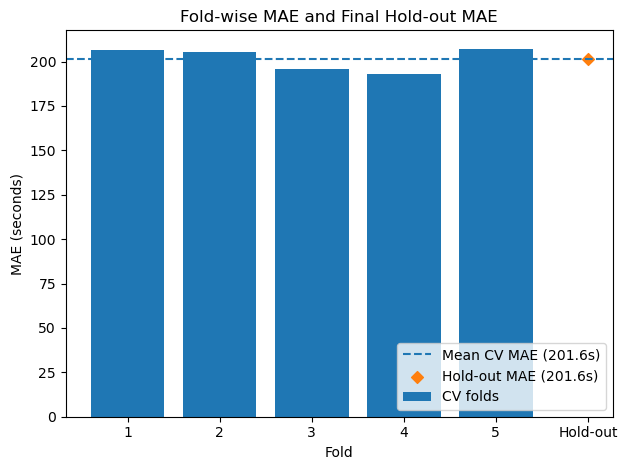

In [132]:
fold_maes = [206.727, 205.509, 195.620, 193.070, 207.244]
holdout_mae = 201.6269
mean_cv = sum(fold_maes)/len(fold_maes)

plt.figure()
plt.bar(range(1,6), fold_maes, label="CV folds")
plt.axhline(mean_cv, linestyle="--", label=f"Mean CV MAE ({mean_cv:.1f}s)")
plt.scatter([6], [holdout_mae], marker="D", label=f"Hold-out MAE ({holdout_mae:.1f}s)")
plt.xlabel("Fold")
plt.ylabel("MAE (seconds)")
plt.xticks(list(range(1,7)), ["1","2","3","4","5","Hold-out"])
plt.legend()
plt.title("Fold-wise MAE and Final Hold-out MAE")
plt.tight_layout()
plt.savefig("fold mae", dpi=300)
plt.show()

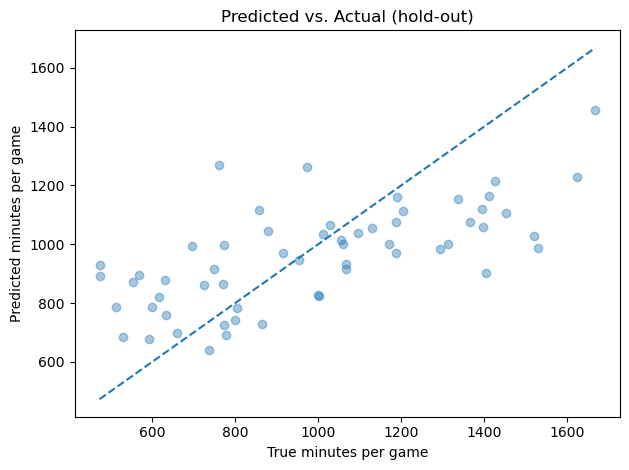

In [133]:
plt.figure()
y_valid = model["y_valid"]
y_pred_valid = model["y_pred_valid"]
plt.scatter(y_valid, y_pred_valid, alpha=0.4)
minv = min(np.min(y_valid), np.min(y_pred_valid))
maxv = max(np.max(y_valid), np.max(y_pred_valid))
plt.plot([minv, maxv], [minv, maxv], linestyle="--")
plt.xlabel("True minutes per game")
plt.ylabel("Predicted minutes per game")
plt.title("Predicted vs. Actual (hold-out)")
plt.tight_layout()
plt.show()

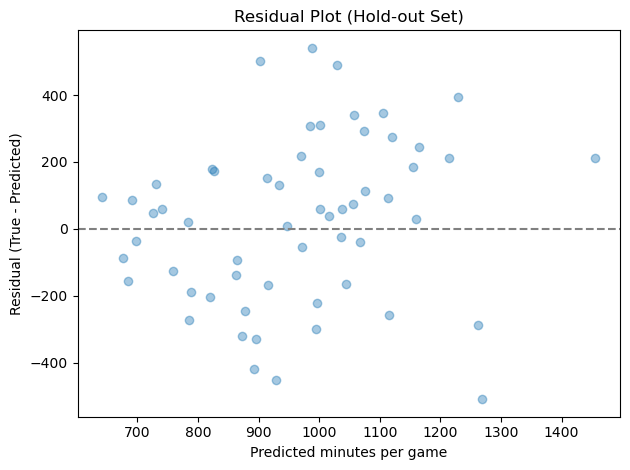

In [311]:
residuals = y_valid - y_pred_valid

# Plot residuals vs. predicted
plt.figure()
plt.scatter(y_pred_valid, residuals, alpha=0.4)
plt.axhline(y=0, linestyle="--", color="gray")
plt.xlabel("Predicted minutes per game")
plt.ylabel("Residual (True - Predicted)")
plt.title("Residual Plot (Hold-out Set)")
plt.tight_layout()
plt.savefig("residuals", dpi=300)
plt.show()

In [115]:
hypothetical_sample = data_merged(hypothetical_df)
hypothetical_sample

,Player 1,Player 2,Team 1,Team 2,Unnamed: 0_1,Player_1,Unnamed: 0_2,Player_2,FGM,FGA,...,TOV_DIFF,PF,PF_DIFF,PTS,PTS_DIFF,DIST,IT1,IT2,IT3,eFG_PCT
0,Bogdan Bogdanovic,A. Horford,ATL,BOS,0,Bogdan Bogdanovic,6,Al Horford,15.480176,33.860453,...,0.874548,6.214355,0.935513,42.572324,10.672224,4.240197,1.925093,1.966845,0.095504,2.400257
1,Bogdan Bogdanovic,J. Brown,ATL,BOS,0,Bogdan Bogdanovic,7,Jaylen Brown,22.621763,48.441208,...,1.261903,7.474124,0.324256,60.555766,7.311218,3.529205,1.854784,1.201777,0.077677,2.354527
2,Bogdan Bogdanovic,J. Holiday,ATL,BOS,0,Bogdan Bogdanovic,8,Jrue Holiday,16.629683,37.004083,...,0.469072,5.931688,1.218180,45.389015,7.855533,2.696935,2.417446,1.454326,0.081529,2.440132
3,Bogdan Bogdanovic,S. Hauser,ATL,BOS,0,Bogdan Bogdanovic,9,Sam Hauser,16.469448,37.796298,...,1.329164,6.383026,0.766842,46.817848,6.426700,2.135956,1.480374,0.974360,0.068736,2.613390
4,Bogdan Bogdanovic,P. Pritchard,ATL,BOS,0,Bogdan Bogdanovic,10,Payton Pritchard,17.438798,39.141938,...,0.587134,6.441620,0.708248,47.906062,5.338486,1.734811,2.371821,0.429394,0.084435,2.487878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36251,D. Smith,B. Miller,BRK,CHO,269,Dennis Smith,265,Brandon Miller,16.619532,38.093497,...,0.387430,9.596170,1.935928,43.802587,9.206292,5.755344,2.340893,1.806927,0.280432,2.449820
36252,D. Smith,Miles Bridges,BRK,CHO,269,Dennis Smith,266,Miles Bridges,17.498617,38.808726,...,0.507045,8.008411,3.523687,44.997913,10.401618,5.678482,2.356619,1.348271,0.273841,2.362773
36253,D. Smith,Cody Martin,BRK,CHO,269,Dennis Smith,267,Cody Martin,12.132737,29.846634,...,0.210875,8.883682,2.648416,31.052412,3.543883,4.207212,2.593216,2.259070,0.330361,2.625332
36254,D. Smith,I. Smith,BRK,CHO,269,Dennis Smith,270,Ish Smith,11.116628,26.337697,...,0.009833,8.921000,2.611098,26.476187,8.120108,4.896366,3.898575,0.751719,0.316086,2.461538


In [123]:
X_test = hypothetical_sample.drop(columns=["Player 1", "Player 2", "Team 1", "Team 2", "Unnamed: 0_1", "Player_1", "Unnamed: 0_2", "Player_2"])
X_test = X_test[X.columns]
dtest = xgb.DMatrix(X_test)
final_model = model["final_model"]
y_test_pred = final_model.predict(dtest)
hypothetical_duos = pd.concat([hypothetical_sample, pd.DataFrame(y_test_pred)], axis=1)
hypothetical_duos = hypothetical_duos.rename(columns={0: "Predicted_MP_per_GP"})

In [124]:
hypothetical_duos = hypothetical_duos.sort_values(by="Predicted_MP_per_GP", ascending=False)
hypothetical_duos

,Player 1,Player 2,Team 1,Team 2,Unnamed: 0_1,Player_1,Unnamed: 0_2,Player_2,FGM,FGA,...,PF,PF_DIFF,PTS,PTS_DIFF,DIST,IT1,IT2,IT3,eFG_PCT,Predicted_MP_per_GP
8805,N. Vucevic,Miles Bridges,CHI,CHO,20,Nikola Vucevic,266,Miles Bridges,21.875277,46.210100,...,5.870870,1.386146,53.863215,1.536315,3.281716,1.497920,0.995012,0.122180,2.223760,1612.266479
28217,P. Siakam,Miles Bridges,TOR,CHO,74,Pascal Siakam,266,Miles Bridges,22.275159,45.302124,...,5.345174,0.860450,58.549561,3.150031,2.088592,1.889323,0.588035,0.066430,2.145081,1593.962158
7555,C. White,P. Siakam,CHI,TOR,15,Coby White,74,Pascal Siakam,20.950815,43.135918,...,6.320801,0.115178,56.957034,4.742558,2.851338,2.385036,0.341219,0.069122,2.207802,1591.132690
26961,P. Siakam,T. Maxey,TOR,PHI,74,Pascal Siakam,147,Tyrese Maxey,23.551829,48.821599,...,5.933675,0.271949,64.895141,3.195549,3.027767,2.549986,0.583704,0.066392,2.188987,1570.408936
26624,P. Siakam,J. Clarkson,IND,UTA,75,Pascal Siakam,182,Jordan Clarkson,22.550695,46.857624,...,6.159768,1.513468,58.578982,4.544242,2.434072,2.343959,0.369041,0.122833,2.215690,1557.610962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25514,Jeff Green,I. Smith,HOU,CHO,65,Jeff Green,270,Ish Smith,10.497286,24.189350,...,6.864580,0.554678,28.060050,9.703971,2.643280,2.264305,0.744781,0.086743,2.425150,543.632874
25166,J. Tate,S. Fontecchio,HOU,UTA,62,Jae'Sean Tate,179,Simone Fontecchio,11.774464,25.657420,...,9.811267,3.074134,30.968483,6.044167,3.813145,1.041146,1.179302,0.134050,2.366532,542.228760
24807,Jeff Green,A. Black,HOU,ORL,65,Jeff Green,139,Anthony Black,11.089062,24.088662,...,8.390828,0.971571,32.329821,5.434201,2.347616,1.152465,1.121654,0.083001,2.329498,540.187683
34058,A. Black,L. Shamet,ORL,WAS,139,Anthony Black,250,Landry Shamet,12.480078,28.126595,...,9.567160,0.204761,34.470299,7.574679,3.027787,1.336901,1.196958,0.069001,2.427653,536.726868


In [347]:
all_stats.columns

Index(['Player 1', 'Player 2', 'Team 1', 'Team 2', 'Player_1', 'Age_1', 'GP_1',
       'GS_1', 'MIN_1', 'Player_2', 'Age_2', 'GP_2', 'GS_2', 'MIN_2', 'IT1',
       'IT2', 'IT3', 'FGM', 'FGA', 'FG_PCT', 'eFG_PCT', 'FG3M', 'FG3A',
       'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'AST', 'AST_PCT', 'AST_DIFF', 'OREB',
       'OREB_PCT', 'OREB_DIFF', 'DREB', 'DREB_PCT', 'DREB_DIFF', 'STL',
       'STL_PCT', 'STL_DIFF', 'BLK', 'BLK_PCT', 'BLK_DIFF', 'TOV', 'TOV_PCT',
       'TOV_DIFF', 'PF', 'PF_DIFF', 'PTS', 'PTS_DIFF', 'DIST',
       'Predicted_MP_per_GP', 'Score', 'Unnamed: 0_1', 'Unnamed: 0_2'],
      dtype='object')

In [125]:
stats_2324_merged = stats_2324_merged.rename(columns={"Team": "Team 1"})
stats_2324_merged.insert(stats_2324_merged.columns.get_loc("Team 1") + 1, "Team 2", stats_2324_merged["Team 1"])
stats_2324_merged = stats_2324_merged.drop(columns=["MP_per_GP", "Unnamed: 0_1", "Unnamed: 0_2"])
stats_2324_merged = stats_2324_merged.rename(columns={"SEC": "Predicted_MP_per_GP"})

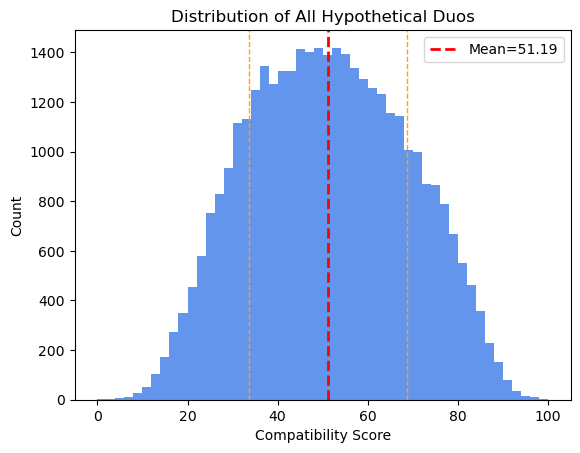

In [304]:
# all_stats = pd.concat([stats_2324_merged, hypothetical_duos], ignore_index=True)
hypothetical = hypothetical_duos.sort_values(by="Predicted_MP_per_GP", ascending=False)
log_transformed = np.log(hypothetical["Predicted_MP_per_GP"])
double_log_transformed = np.log(log_transformed) 
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(double_log_transformed.values.reshape(-1, 1))
hypothetical["Score"] = scaled_data * 100
hmean = hypothetical["Score"].mean()
hstd = hypothetical["Score"].std()
plt.hist(hypothetical["Score"], color="cornflowerblue", bins=50)
plt.axvline(x=hmean, color='r', linestyle='--', linewidth=2, label='Mean=51.19')
plt.axvline(x=hmean+hstd, color='orange', linestyle='--', linewidth=1)
plt.axvline(x=hmean-hstd, color='orange', linestyle='--', linewidth=1)
plt.title("Distribution of All Hypothetical Duos")
plt.ylabel("Count")
plt.xlabel("Compatibility Score")
plt.legend()
plt.savefig("hypothetical", dpi=300)
plt.show()

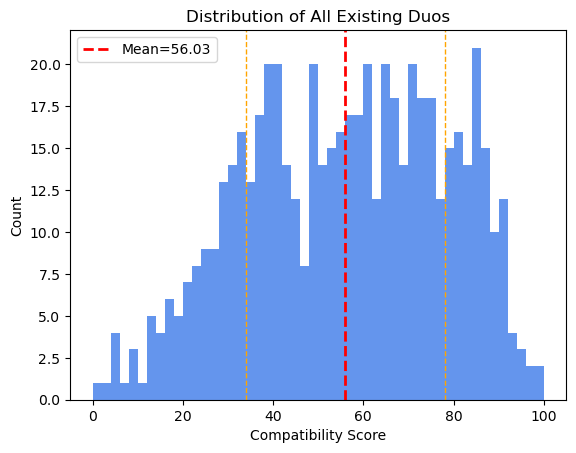

In [226]:
# all_stats = pd.concat([stats_2324_merged, hypothetical_duos], ignore_index=True)
stats2324 = stats_2324_merged.sort_values(by="Predicted_MP_per_GP", ascending=False)
log_transformed = np.log(stats2324["Predicted_MP_per_GP"])
double_log_transformed = np.log(log_transformed) 
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(double_log_transformed.values.reshape(-1, 1))
stats2324["Score"] = scaled_data * 100
smean = stats2324["Score"].mean()
sstd = stats2324["Score"].std()
plt.hist(stats2324["Score"], color="cornflowerblue", bins=50)
plt.axvline(x=smean, color='r', linestyle='--', linewidth=2, label='Mean=56.03')
plt.axvline(x=smean+sstd, color='orange', linestyle='--', linewidth=1)
plt.axvline(x=smean-sstd, color='orange', linestyle='--', linewidth=1)
plt.title("Distribution of All Existing Duos")
plt.ylabel("Count")
plt.xlabel("Compatibility Score")
plt.legend()
plt.savefig("existing", dpi=300)
plt.show()

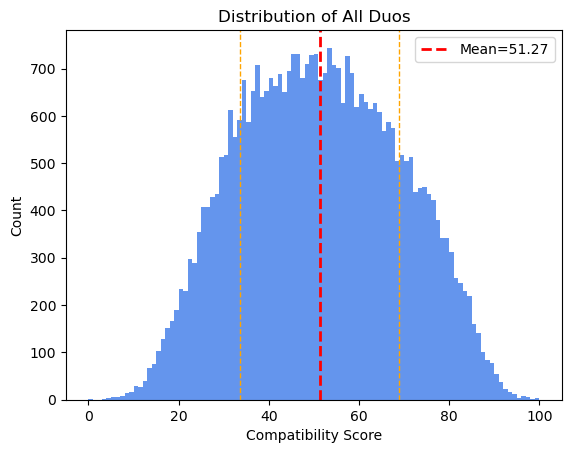

In [229]:
all_stats = pd.concat([stats2324, hypothetical], ignore_index=True)
all_stats = all_stats.sort_values(by="Score", ascending=False)
amean = all_stats["Score"].mean()
astd = all_stats["Score"].std()
plt.hist(all_stats["Score"], color="cornflowerblue", bins=100)
plt.axvline(x=amean, color='r', linestyle='--', linewidth=2, label='Mean=51.27')
plt.axvline(x=amean+astd, color='orange', linestyle='--', linewidth=1)
plt.axvline(x=amean-astd, color='orange', linestyle='--', linewidth=1)
plt.title("Distribution of All Duos")
plt.ylabel("Count")
plt.xlabel("Compatibility Score")
plt.legend()
plt.savefig("all", dpi=300)
plt.show()

In [313]:
all_stats

,Player 1,Player 2,Team 1,Team 2,Player_1,Age_1,GP_1,GS_1,MIN_1,Player_2,...,TOV_DIFF,PF,PF_DIFF,PTS,PTS_DIFF,DIST,Predicted_MP_per_GP,Score,Unnamed: 0_1,Unnamed: 0_2
0,Z. LaVine,N. Vucevic,CHI,CHI,Zach LaVine,29.0,25.0,23.0,34.880000,Nikola Vucevic,...,0.680674,6.886675,0.370341,54.000770,1.673870,3.641629,1826.014000,100.000000,NaN,NaN
576,N. Vucevic,Miles Bridges,CHI,CHO,Nikola Vucevic,NaN,NaN,NaN,NaN,Miles Bridges,...,0.346384,5.870870,1.386146,53.863215,1.536315,3.281716,1612.266479,100.000000,20.0,266.0
577,P. Siakam,Miles Bridges,TOR,CHO,Pascal Siakam,NaN,NaN,NaN,NaN,Miles Bridges,...,0.322081,5.345174,0.860450,58.549561,3.150031,2.088592,1593.962158,99.077606,74.0,266.0
578,C. White,P. Siakam,CHI,TOR,Coby White,NaN,NaN,NaN,NaN,Pascal Siakam,...,0.088185,6.320801,0.115178,56.957034,4.742558,2.851338,1591.132690,98.933884,15.0,74.0
1,J. Brunson,J. Randle,NYK,NYK,Jalen Brunson,27.0,77.0,77.0,35.402597,Julius Randle,...,1.478025,6.530005,1.203149,75.000956,6.825465,3.712687,1782.027000,98.438195,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36829,Jeff Green,A. Black,HOU,ORL,Jeff Green,NaN,NaN,NaN,NaN,Anthony Black,...,0.676727,8.390828,0.971571,32.329821,5.434201,2.347616,540.187683,4.472542,65.0,139.0
36830,A. Black,L. Shamet,ORL,WAS,Anthony Black,NaN,NaN,NaN,NaN,Landry Shamet,...,0.454487,9.567160,0.204761,34.470299,7.574679,3.027787,536.726868,3.863239,139.0,250.0
574,J. Ivey,J. Wiseman,DET,DET,Jaden Ivey,22.0,77.0,61.0,28.805195,James Wiseman,...,1.210475,10.639550,1.792280,45.357805,6.034429,6.923612,465.053000,3.451563,NaN,NaN
575,Jeff Green,A. Holiday,HOU,HOU,Jeff Green,37.0,78.0,6.0,16.756410,Aaron Holiday,...,0.318549,8.485520,1.066262,38.520476,0.756454,2.175241,445.040000,0.000000,NaN,NaN


In [167]:
print(all_stats["Score"].mean())
print(all_stats["Score"].std())

51.26526189272703
17.679674108663885


In [2]:
season_stats = pd.read_csv("season_stats.csv")
# season_stats.drop('Unnamed: 0', axis=1, inplace=True)
alllineup_stats = pd.read_csv("alllineup_stats.csv")
extra_stats = pd.read_csv("Extra Stats.csv")
team_misc_stats = pd.read_csv("team_misc.csv")
team_misc_stats = team_misc_stats.drop(team_misc_stats.iloc[1::2].index)
team_stats = pd.read_csv("team_stats.csv")
stats_2324 = pd.read_csv("stats_2324.csv")
all_stats = pd.read_csv("all_stats.csv")

In [181]:
stats2324.columns

Index(['Player 1', 'Player 2', 'Team 1', 'Team 2', 'Player_1', 'Age_1', 'GP_1',
       'GS_1', 'MIN_1', 'Player_2', 'Age_2', 'GP_2', 'GS_2', 'MIN_2', 'IT1',
       'IT2', 'IT3', 'FGM', 'FGA', 'FG_PCT', 'eFG_PCT', 'FG3M', 'FG3A',
       'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'AST', 'AST_PCT', 'AST_DIFF', 'OREB',
       'OREB_PCT', 'OREB_DIFF', 'DREB', 'DREB_PCT', 'DREB_DIFF', 'STL',
       'STL_PCT', 'STL_DIFF', 'BLK', 'BLK_PCT', 'BLK_DIFF', 'TOV', 'TOV_PCT',
       'TOV_DIFF', 'PF', 'PF_DIFF', 'PTS', 'PTS_DIFF', 'DIST',
       'Predicted_MP_per_GP', 'Score'],
      dtype='object')

In [180]:
def Deaaron(player):
    deaaron = all_stats[(all_stats["Player_1"] == player) | (all_stats["Player_2"] == player)]
    deaaron = deaaron[deaaron["Team 1"] != deaaron["Team 2"]][["Player_1", "Player_2", "Score"]].head()
    deaaron["Top Matches"] = deaaron.apply(
        lambda row: row["Player_2"] if row["Player_1"] == player else row["Player_1"],
        axis=1
    )
    deaaron5 = deaaron[["Top Matches", "Score"]].head()
    deaaron5 = deaaron5.reset_index(drop=True)
    display(Markdown(player))
    display(deaaron5)
Deaaron("Pascal Siakam")

Pascal Siakam

,Top Matches,Score
0,Miles Bridges,99.077606
1,Coby White,98.933884
2,Tyrese Maxey,97.872833
3,Jordan Clarkson,97.209641
4,Jalen Brunson,96.535400


In [182]:
win_pct = team_misc_stats[["Team", "W", "L"]].copy()
win_pct["W%"] = win_pct["W"] / 82
win_pct = win_pct.drop(columns=(["W", "L"]))
beta = pd.DataFrame(stats2324.groupby(by="Team 1", as_index=False)["Score"].mean())
beta = beta.rename(columns={"Team 1": "Team"})
win_pct = win_pct.merge(beta, how="inner", on="Team")
win_pct_sorted = win_pct.sort_values(by="W%")

In [183]:
win_pct_sorted

,Team,W%,Score
8,DET,0.170732,49.163788
29,WAS,0.182927,56.536096
3,CHO,0.256098,66.319634
24,POR,0.256098,45.817422
26,SAS,0.268293,49.154868
27,TOR,0.304878,70.602165
14,MEM,0.329268,42.571112
28,UTA,0.378049,45.944552
2,BRK,0.390244,56.784009
0,ATL,0.439024,68.272186


In [208]:
X = pd.DataFrame(win_pct_sorted["W%"])
y = pd.DataFrame(win_pct_sorted["Score"])# .reset_index(drop=True)
display(y)
y.iloc[[10, 24]] = y.iloc[[24, 10]].values
y.iloc[[16, 27]] = y.iloc[[27, 16]].values

,Score
8,49.163788
29,56.536096
3,66.319634
24,45.817422
26,49.154868
27,70.602165
14,42.571112
28,45.944552
2,56.784009
0,68.272186


                            OLS Regression Results                            
Dep. Variable:                  Score   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     2.054
Date:                Tue, 29 Apr 2025   Prob (F-statistic):              0.163
Time:                        11:55:25   Log-Likelihood:                -100.44
No. Observations:                  30   AIC:                             204.9
Df Residuals:                      28   BIC:                             207.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.4510      4.248     11.875      0.0

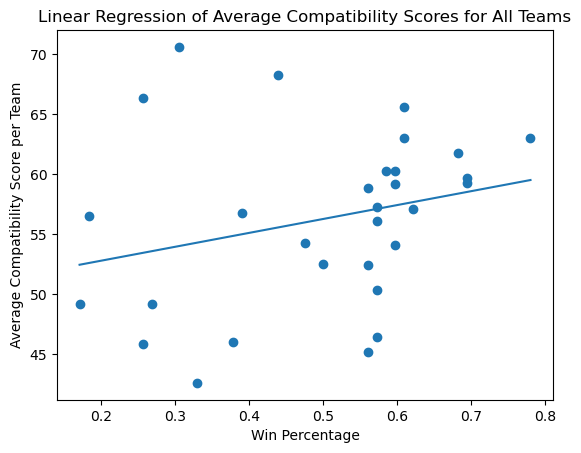

In [230]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

model = LinearRegression()
X1 = X
y1 = y
model.fit(X1, y1)
m = model.coef_[0]
b = model.intercept_
y_pred = model.predict(X1)

X_sm = sm.add_constant(X1) 
model_sm = sm.OLS(y1, X_sm).fit()
print(model_sm.summary())

plt.scatter(X1, y1)
plt.plot(X1, y_pred)
# plt.xticks(win_pct_sorted["Team"], rotation=90)
plt.xlabel("Win Percentage")
plt.ylabel("Average Compatibility Score per Team")
plt.title("Linear Regression of Average Compatibility Scores for All Teams")
plt.savefig('all teams.png', dpi=300)
plt.show()

                            OLS Regression Results                            
Dep. Variable:                  Score   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                 -0.077
Method:                 Least Squares   F-statistic:                    0.3598
Date:                Tue, 29 Apr 2025   Prob (F-statistic):              0.565
Time:                        11:56:00   Log-Likelihood:                -36.697
No. Observations:                  10   AIC:                             77.39
Df Residuals:                       8   BIC:                             78.00
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         47.9375     12.430      3.856      0.0

/Users/sydnee/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  res = hypotest_fun_out(*samples, **kwds)


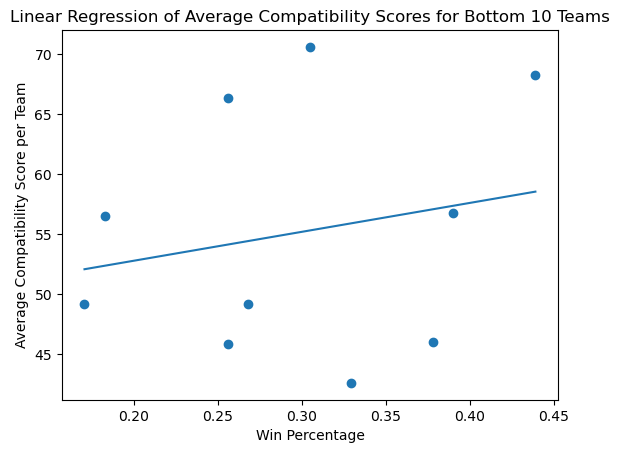

In [232]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

model = LinearRegression()
X1 = X[0:10]
y1 = y[0:10]
model.fit(X1, y1)
m = model.coef_[0]
b = model.intercept_
y_pred = model.predict(X1)

X_sm = sm.add_constant(X1) 
model_sm = sm.OLS(y1, X_sm).fit()
print(model_sm.summary())

plt.scatter(X1, y1)
plt.plot(X1, y_pred)
# plt.xticks(win_pct_sorted["Team"], rotation=90)
plt.xlabel("Win Percentage")
plt.ylabel("Average Compatibility Score per Team")
plt.title("Linear Regression of Average Compatibility Scores for Bottom 10 Teams")
plt.savefig('0-10.png', dpi=300)
plt.show()

                            OLS Regression Results                            
Dep. Variable:                  Score   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     7.428
Date:                Tue, 29 Apr 2025   Prob (F-statistic):             0.0139
Time:                        11:56:16   Log-Likelihood:                -58.317
No. Observations:                  20   AIC:                             120.6
Df Residuals:                      18   BIC:                             122.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         31.2779      9.428      3.318      0.0

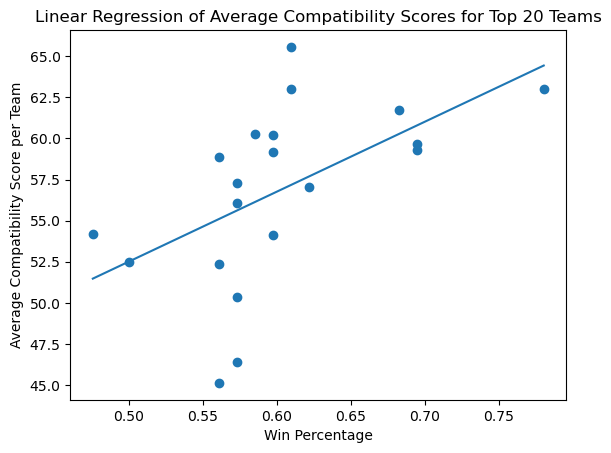

In [233]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

model = LinearRegression()
X2 = X[10:30]
y2 = y[10:30]
model.fit(X2, y2)
m = model.coef_[0]
b = model.intercept_
y_pred = model.predict(X2)

X_sm = sm.add_constant(X2) 
model_sm = sm.OLS(y2, X_sm).fit()
print(model_sm.summary())

plt.scatter(X2, y2)
plt.plot(X2, y_pred)
# plt.xticks(win_pct_sorted["Team"], rotation=90)
plt.xlabel("Win Percentage")
plt.ylabel("Average Compatibility Score per Team")
plt.title("Linear Regression of Average Compatibility Scores for Top 20 Teams")
plt.savefig('10-30.png', dpi=300)
plt.show()


In [265]:
re = all_stats[(all_stats["Player_1"] == "Kevin Durant") | (all_stats["Player_2"] == "Kevin Durant")]
re1 = re[re["Team 1"] != "PHO"]
team_avg_scores = re1.groupby("Team 1")["Score"].mean()
print(team_avg_scores.sort_values())
re2 = re[re["Team 2"] != "PHO"]
team_avg_scores2 = re2.groupby("Team 2")["Score"].mean()
print(team_avg_scores2)

er = all_stats[(all_stats["Player_1"] == "OG Anunoby") | (all_stats["Player_2"] == "OG Anunoby")]
er1 = er[er["Team 1"] != "NYK"]
team_avg_scores1 = er1.groupby("Team 1")["Score"].mean()
print(team_avg_scores1.sort_values())
er2 = er[er["Team 2"] != "NYK"]
team_avg_scores3 = er2.groupby("Team 2")["Score"].mean()
print(team_avg_scores3)

Team 1
ORL    56.015889
MEM    60.217172
DAL    61.107188
GSW    61.895509
OKC    62.189267
HOU    62.244015
NOP    63.241719
POR    63.462801
NYK    63.732571
PHI    64.117623
UTA    65.164197
MIN    66.321398
DET    66.386169
SAC    66.533098
WAS    66.543829
MIA    66.634201
CHI    66.635926
LAC    66.782179
LAL    67.473983
MIL    69.536029
CLE    69.772553
BOS    69.845866
SAS    69.848421
IND    70.224723
DEN    72.499573
ATL    72.993268
TOR    73.866348
Name: Score, dtype: float64
Team 2
BRK    62.009417
CHO    65.062275
Name: Score, dtype: float64
Team 1
OKC    49.265211
HOU    49.742365
DET    55.361059
LAL    55.910312
TOR    56.167214
DAL    56.261759
GSW    56.762970
MIA    57.592694
CHI    58.414523
IND    59.244767
CLE    62.391984
BOS    62.754811
DEN    63.634419
ATL    65.767622
Name: Score, dtype: float64
Team 2
BRK    53.352586
CHO    57.559892
LAC    58.592298
MEM    51.078632
MIL    59.317863
MIN    59.338271
NOP    57.656968
ORL    44.809953
PHI    55.760787
PHO 

In [269]:
er[(er["Team 1"] == "MIN")|(er["Team 2"] == "MIN")][["Player_1", "Player_2", "Score"]]

,Player_1,Player_2,Score
2036,OG Anunoby,Anthony Edwards,81.516739
4509,OG Anunoby,Karl-Anthony Towns,74.639984
7996,OG Anunoby,Rudy Gobert,67.376328
10140,OG Anunoby,Mike Conley,63.692570
17709,OG Anunoby,Jaden McDaniels,52.253437
19465,OG Anunoby,Naz Reid,49.731827
22497,OG Anunoby,Kyle Anderson,45.466423
26143,OG Anunoby,Nickeil Alexander-Walker,40.028858


In [349]:
all_stats

,Player 1,Player 2,Team 1,Team 2,Player_1,Age_1,GP_1,GS_1,MIN_1,Player_2,...,TOV_DIFF,PF,PF_DIFF,PTS,PTS_DIFF,DIST,Predicted_MP_per_GP,Score,Unnamed: 0_1,Unnamed: 0_2
0,Z. LaVine,N. Vucevic,CHI,CHI,Zach LaVine,29.0,25.0,23.0,34.880000,Nikola Vucevic,...,0.680674,6.886675,0.370341,54.000770,1.673870,3.641629,1826.014000,100.000000,NaN,NaN
576,N. Vucevic,Miles Bridges,CHI,CHO,Nikola Vucevic,NaN,NaN,NaN,NaN,Miles Bridges,...,0.346384,5.870870,1.386146,53.863215,1.536315,3.281716,1612.266479,100.000000,20.0,266.0
577,P. Siakam,Miles Bridges,TOR,CHO,Pascal Siakam,NaN,NaN,NaN,NaN,Miles Bridges,...,0.322081,5.345174,0.860450,58.549561,3.150031,2.088592,1593.962158,99.077606,74.0,266.0
578,C. White,P. Siakam,CHI,TOR,Coby White,NaN,NaN,NaN,NaN,Pascal Siakam,...,0.088185,6.320801,0.115178,56.957034,4.742558,2.851338,1591.132690,98.933884,15.0,74.0
1,J. Brunson,J. Randle,NYK,NYK,Jalen Brunson,27.0,77.0,77.0,35.402597,Julius Randle,...,1.478025,6.530005,1.203149,75.000956,6.825465,3.712687,1782.027000,98.438195,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36829,Jeff Green,A. Black,HOU,ORL,Jeff Green,NaN,NaN,NaN,NaN,Anthony Black,...,0.676727,8.390828,0.971571,32.329821,5.434201,2.347616,540.187683,4.472542,65.0,139.0
36830,A. Black,L. Shamet,ORL,WAS,Anthony Black,NaN,NaN,NaN,NaN,Landry Shamet,...,0.454487,9.567160,0.204761,34.470299,7.574679,3.027787,536.726868,3.863239,139.0,250.0
574,J. Ivey,J. Wiseman,DET,DET,Jaden Ivey,22.0,77.0,61.0,28.805195,James Wiseman,...,1.210475,10.639550,1.792280,45.357805,6.034429,6.923612,465.053000,3.451563,NaN,NaN
575,Jeff Green,A. Holiday,HOU,HOU,Jeff Green,37.0,78.0,6.0,16.756410,Aaron Holiday,...,0.318549,8.485520,1.066262,38.520476,0.756454,2.175241,445.040000,0.000000,NaN,NaN


In [300]:
re1[re1["Team 1"] == "SAS"][["Player_1", "Player_2", "Score"]]

,Player_1,Player_2,Score
1861,Devin Vassell,Kevin Durant,82.258415
3358,Malaki Branham,Kevin Durant,77.450089
3519,Tre Jones,Kevin Durant,76.986404
4070,Keldon Johnson,Kevin Durant,75.633240
4754,Jeremy Sochan,Kevin Durant,74.068069
6886,Victor Wembanyama,Kevin Durant,69.540405
11512,Zach Collins,Kevin Durant,61.481953
12303,Cedi Osman,Kevin Durant,60.237312
18573,Julian Champagnie,Kevin Durant,50.979900


In [490]:
stats_player1 = stats_2324_norm.rename(columns={"Player": "Player_1", "Team": "Team 1_x", "Cluster": "Cluster 1"})
stats_player2 = stats_2324_norm.rename(columns={"Player": "Player_2", "Team": "Team 2_x", "Cluster": "Cluster 2"})
merged_df = pd.merge(normalized_scores, stats_player1[["Player_1", "Team 1_x", "Cluster 1"]], on=["Player_1", "Team 1_x"], how="left")
merged_df = pd.merge(merged_df, stats_player2[["Player_2", "Team 2_x", "Cluster 2"]], on=["Player_2", "Team 2_x"], how="left")
merged_df

,Player_1,Player_2,Team 1_x,Team 2_x,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,...,Normalized_Min,IT1,IT2,IT3,IT4,IT5,IT6,eFG%,Cluster 1,Cluster 2
0,Keegan Murray,Domantas Sabonis,SAC,SAC,18.832644,36.016877,0.523996,3.981578,11.032548,0.368716,...,2489.423335,0.918199,3.999065,1.180684,1.359406,0.027392,0.060464,0.578644,5,3
1,Kentavious Caldwell-Pope,Aaron Gordon,DEN,DEN,14.165743,27.574741,0.507916,3.443999,9.337430,0.347850,...,2422.223681,1.095027,2.269154,1.965334,1.048178,0.008865,0.050486,0.575119,5,3
2,Kentavious Caldwell-Pope,Michael Porter Jr.,DEN,DEN,15.665212,32.977312,0.471874,6.833551,17.068308,0.401478,...,2326.161348,1.500227,0.957189,2.072876,0.703996,0.008894,0.027542,0.576084,5,5
3,Zach LaVine,Nikola Vucevic,CHI,CHI,20.908421,44.619431,0.468013,5.129450,15.637668,0.321521,...,2315.731649,1.646524,1.693454,1.375446,0.436649,0.005366,0.047849,0.526234,2,3
4,Kentavious Caldwell-Pope,Nikola Jokic,DEN,DEN,20.466206,37.681370,0.521266,4.084222,10.543411,0.382576,...,2302.949469,1.357407,5.205754,2.492407,1.696512,0.009293,0.054302,0.589208,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39687,Chet Holmgren,Isaiah Joe,OKC,OKC,17.454891,35.138318,0.493819,7.464073,18.705758,0.393029,...,189.421354,1.660068,1.217986,0.773561,5.798393,0.037564,0.015262,0.603432,3,5
39688,Jaden Ivey,Marcus Sasser,DET,DET,16.838927,39.326430,0.428153,5.892916,16.545681,0.355522,...,178.431134,2.406978,2.823337,0.528032,1.392647,0.021854,0.004381,0.503958,2,2
39689,Jalen Green,Jeff Green,HOU,HOU,16.689878,38.406852,0.439478,5.712914,17.213120,0.331741,...,172.558319,1.796861,0.862719,1.414822,0.309795,0.008849,0.018615,0.513406,2,5
39690,Jaden Ivey,James Wiseman,DET,DET,17.286233,34.544779,0.520843,2.688876,8.089745,0.168022,...,172.017334,0.000000,0.799972,2.125076,0.470327,0.025986,0.054256,0.552703,2,1


In [491]:
import itertools

# Example: If your individual player data is in stats_2324_norm, and it contains columns "Player", "Team", "Cluster".
# Create buckets for each required slot:

# Bucket A: Players whose cluster is 0 OR 2.
bucket_A = stats_2324_norm[stats_2324_norm["Cluster"].isin([0, 2])]["Player"].unique()

# Bucket B: Players with cluster 1.
bucket_B = stats_2324_norm[stats_2324_norm["Cluster"] == 1]["Player"].unique()

# Bucket C: Players with cluster 3.
bucket_C = stats_2324_norm[stats_2324_norm["Cluster"] == 3]["Player"].unique()

# Bucket D: Players with cluster 4.
bucket_D = stats_2324_norm[stats_2324_norm["Cluster"] == 4]["Player"].unique()

# Bucket E: Players with cluster 5.
bucket_E = stats_2324_norm[stats_2324_norm["Cluster"] == 5]["Player"].unique()

# --- Build a lookup dictionary for compatibility scores ---
# Assume merged_df has columns: "Player_1", "Player_2", and "Score".
# We create a dictionary keyed by a sorted tuple of two players.
score_dict = {}
for _, row in merged_df.iterrows():
    players = tuple(sorted([row["Player_1"], row["Player_2"]]))
    score_dict[players] = row["Score"]

def lineup_avg_score(lineup):
    """
    Given a list of 5 players (the lineup), compute the average compatibility score 
    using the scores from score_dict for each pair in the lineup.
    """
    pairs = list(itertools.combinations(lineup, 2))
    scores = []
    for p1, p2 in pairs:
        # Sort the two player names to build the lookup key.
        key = tuple(sorted([p1, p2]))
        # If the pair is not found, you can decide on a default score (for example, 0).
        scores.append(score_dict.get(key, 0))
    return np.mean(scores)

# --- Iterate over all candidate lineups ---
# Note: The following nested loops form a complete search over the cartesian product
# of the buckets. Depending on the sizes of your buckets, this might be computationally intensive.
best_lineup = None
best_avg_score = -np.inf  # start with minus infinity for maximization

# Iterate over every possibility (one player from each bucket)
for pA in bucket_A:
    for pB in bucket_B:
        for pC in bucket_C:
            for pD in bucket_D:
                for pE in bucket_E:
                    lineup = [pA, pB, pC, pD, pE]
                    avg_score = lineup_avg_score(lineup)
                    if avg_score > best_avg_score:
                        best_avg_score = avg_score
                        best_lineup = lineup

print("Best lineup:", best_lineup)
print("Best average compatibility score:", best_avg_score)


Best lineup: ['Nikola Jokic', 'Rudy Gobert', 'Aaron Gordon', 'Mike Conley', 'Kentavious Caldwell-Pope']
Best average compatibility score: 82.82376619287149


In [ ]:
lineup_scores_dict

In [494]:
display(stats_2324_norm[stats_2324_norm["Player"] == "Mike Conley"]["Cluster"])
display(stats_2324_norm[stats_2324_norm["Player"] == "Nikola Jokic"]["Cluster"])
display(stats_2324_norm[stats_2324_norm["Player"] == "Aaron Gordon"]["Cluster"])
display(stats_2324_norm[stats_2324_norm["Player"] == "Kentavious Caldwell-Pope"]["Cluster"])
display(stats_2324_norm[stats_2324_norm["Player"] == "Rudy Gobert"]["Cluster"])

112    4
Name: Cluster, dtype: int32

40    0
Name: Cluster, dtype: int32

41    3
Name: Cluster, dtype: int32

42    5
Name: Cluster, dtype: int32

111    1
Name: Cluster, dtype: int32

In [43]:
def objective(trial):
    params = {
        "objective": "reg:squarederror",
        "eval_metric": "mae",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "lambda": trial.suggest_float("lambda", 1e-3, 10, log=True),  # L2 regularization
        "alpha": trial.suggest_float("alpha", 1e-3, 10, log=True),    # L1 regularization
        "min_child_weight": trial.suggest_float("min_child_weight", 1, 20, log=True),
        # "random_state": 42,
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mae_scores = []
    best_iterations = []

    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        dtrain = xgb.DMatrix(X_train, label=y_train)
        dval = xgb.DMatrix(X_val, label=y_val)

        max_boost_rounds = 5000
        model = xgb.train(
            params,
            dtrain,
            num_boost_round=max_boost_rounds,
            evals=[(dval, "Validation")],
            early_stopping_rounds=100,
            verbose_eval=False
        )

        best_iterations.append(model.best_iteration)
        y_pred = model.predict(dval)
        mae_scores.append(mean_absolute_error(y_val, y_pred))

    avg_best_iteration = int(np.mean(best_iterations))
    trial.set_user_attr("best_num_boost_round", avg_best_iteration)

    return np.mean(mae_scores)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("Best hyperparameters:", study.best_params)
print("Best average num_boost_round:", study.best_trial.user_attrs["best_num_boost_round"])

[I 2025-04-10 13:47:33,482] A new study created in memory with name: no-name-31fb541a-0113-4790-8320-c835cbbb30e6
[I 2025-04-10 13:47:34,247] Trial 0 finished with value: 205.25355512198615 and parameters: {'learning_rate': 0.09996767447630074, 'max_depth': 9, 'subsample': 0.5927864154329308, 'colsample_bytree': 0.5518587824738148, 'lambda': 0.0576952425163437, 'alpha': 1.7763030147484713, 'min_child_weight': 19.552751491162734}. Best is trial 0 with value: 205.25355512198615.
[I 2025-04-10 13:47:42,370] Trial 1 finished with value: 202.0817712169623 and parameters: {'learning_rate': 0.012935083997709252, 'max_depth': 11, 'subsample': 0.7539994687457752, 'colsample_bytree': 0.865362240732992, 'lambda': 0.9863344745029453, 'alpha': 0.5930507844458963, 'min_child_weight': 4.4840483874445285}. Best is trial 1 with value: 202.0817712169623.
[I 2025-04-10 13:47:42,907] Trial 2 finished with value: 208.7245652436026 and parameters: {'learning_rate': 0.17043040717600125, 'max_depth': 5, 'subs

Best hyperparameters: {'learning_rate': 0.014815808564033127, 'max_depth': 3, 'subsample': 0.7204240724500527, 'colsample_bytree': 0.8730074566604107, 'lambda': 0.031618802012008694, 'alpha': 1.9610506470727835, 'min_child_weight': 5.714326480957027}
Best average num_boost_round: 578


In [165]:
def objective(trial):
    params = {
        "objective": "reg:squarederror",
        "eval_metric": "mae",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "lambda": trial.suggest_float("lambda", 1e-3, 10, log=True),  # L2 regularization
        "alpha": trial.suggest_float("alpha", 1e-3, 10, log=True),    # L1 regularization
        "min_child_weight": trial.suggest_float("min_child_weight", 1, 20, log=True),
        # "random_state": 42,
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mae_scores = []
    best_iterations = []

    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        dtrain = xgb.DMatrix(X_train, label=y_train)
        dval = xgb.DMatrix(X_val, label=y_val)

        max_boost_rounds = 5000
        model = xgb.train(
            params,
            dtrain,
            num_boost_round=max_boost_rounds,
            evals=[(dval, "Validation")],
            early_stopping_rounds=100,
            verbose_eval=False
        )

        best_iterations.append(model.best_iteration)
        y_pred = model.predict(dval)
        mae_scores.append(mean_absolute_error(y_val, y_pred))

    avg_best_iteration = int(np.mean(best_iterations))
    trial.set_user_attr("best_num_boost_round", avg_best_iteration)

    return np.mean(mae_scores)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("Best hyperparameters:", study.best_params)
print("Best average num_boost_round:", study.best_trial.user_attrs["best_num_boost_round"])

[I 2025-04-10 17:40:48,518] A new study created in memory with name: no-name-1d7d6697-be67-4084-a131-a744e78b502d
[I 2025-04-10 17:40:49,663] Trial 0 finished with value: 310.75159941514187 and parameters: {'learning_rate': 0.07323039720393967, 'max_depth': 4, 'subsample': 0.6982230944358234, 'colsample_bytree': 0.7105606937690265, 'lambda': 0.004230112640252244, 'alpha': 0.0020146572377797343, 'min_child_weight': 14.11161190533268}. Best is trial 0 with value: 310.75159941514187.
[I 2025-04-10 17:40:50,561] Trial 1 finished with value: 315.98431227842667 and parameters: {'learning_rate': 0.09292174456306256, 'max_depth': 8, 'subsample': 0.6083974618668917, 'colsample_bytree': 0.6213221213681994, 'lambda': 0.02641858538949171, 'alpha': 0.004041702271737456, 'min_child_weight': 10.171803194541004}. Best is trial 0 with value: 310.75159941514187.
[I 2025-04-10 17:40:51,495] Trial 2 finished with value: 310.04543042657065 and parameters: {'learning_rate': 0.15254583920435708, 'max_depth':

Best hyperparameters: {'learning_rate': 0.0277346218779652, 'max_depth': 5, 'subsample': 0.8147729473693605, 'colsample_bytree': 0.8709546325764835, 'lambda': 0.3687671325331307, 'alpha': 0.1305709972052336, 'min_child_weight': 4.671973265939742}
Best average num_boost_round: 328


/var/folders/61/bpyxxrn50vg4s9fmxmsymnl80000gn/T/ipykernel_5610/3370170674.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


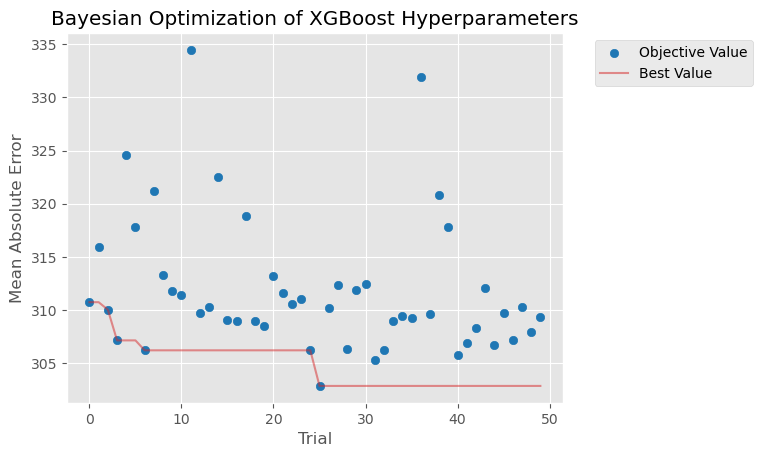

In [473]:
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.title('Bayesian Optimization of XGBoost Hyperparameters')
plt.xlabel('Trial')
plt.ylabel('Mean Absolute Error')
plt.show()